In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from scipy.optimize import curve_fit
import random


import scvi
import pickle
from adjustText import adjust_text

import itertools
from numba import jit

import senepy as sp

## load/harmonize adata

In [2]:

adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')


In [3]:
coords = sc.read_h5ad('../data/tms/TMS_BDATA_UMAP_COORDS.h5ad').obsm['X_umap']
adata.obsm['X_umap'] = coords

In [4]:
hubs = sp.load_hubs(species = 'Mouse')

In [5]:
adata

AnnData object with n_obs × n_vars = 328498 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [6]:
temp = adata.obs.groupby([ 'tissue2', 'cell_type_2']).count()
temp=temp[temp.age > 0]['age']


In [7]:
to_test = temp.reset_index().sort_values('age', ascending = False)
to_test

,tissue2,cell_type_2,age
86,Lymphoid,B cell,41537
100,Myeloid,monocyte,21785
88,Lymphoid,T cell,21779
98,Myeloid,granulocyte,15269
61,Limb_Muscle,mesenchymal stem cell,13972
...,...,...,...
115,Skin,macrophage,13
77,Lung,lung neuroendocrine cell,8
83,Lung,type I pneumocyte,4
42,Kidney,kidney cell,3


In [8]:
#going to pick one hub per cell/tissue. If cell/tissue hub not present, pick cell-type with highest hyp
#if no cell type, pick highest other hyp
def pick_hub(tissue, cell):
    temp = hubs.metadata[(hubs.metadata.tissue == tissue) & (hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata[(hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata.sort_values('hyp')
    return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num) 
        

In [9]:
scores = {}
what_hubs = {}

for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    
    sel_hub = pick_hub(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)
    
    res = sp.score_hub(sub, hubs.hubs[sel_hub])
    
    scores = scores | dict(zip(sub.obs.index, res))
    what_hubs[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sel_hub
    

100%|█████████████████████████████████████████| 138/138 [01:21<00:00,  1.70it/s]


In [10]:
for item in what_hubs:
    print(item, what_hubs[item])

('Bladder', 'bladder cell') ('Bladder', 'bladder cell', 2)
('Bladder', 'bladder urothelial cell') ('Heart_and_Aorta', 'endocardial cell', 0)
('Bladder', 'endothelial cell') ('Bladder', 'endothelial cell', 3)
('Brain', 'astrocyte') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'endothelial cell') ('Fat', 'endothelial cell', 0)
('Brain', 'ependymal cell') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'macrophage') ('Kidney', 'macrophage', 0)
('Brain', 'microglial cell') ('Brain', 'microglial cell', 2)
('Brain', 'neuroepithelial cell') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'neuron') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'neuronal stem cell') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'oligodendrocyte') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'oligodendrocyte precursor cell') ('Heart_and_Aorta', 'endocardial cell', 0)
('Brain', 'pericyte') ('Heart_and_Aorta', 'endocardial cell', 0)
('Diaphragm', 'endothelial cell') ('Fat', 

In [11]:
adata.obs['sen_score'] = adata.obs.index.map(scores)

In [12]:
adata

AnnData object with n_obs × n_vars = 328498 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2', 'sen_score'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [13]:
#means/stds for each tissue-cell

means = {}
stds = {}
for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    means[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.mean()
    stds[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.std()
    

100%|████████████████████████████████████████| 138/138 [00:00<00:00, 234.65it/s]


In [14]:
#means/stds for each tissue-cell-age

means_a = {}
stds_a = {}
for row in tqdm(range(len(to_test))):
    for age in ['3m', '24m']:
        sub = adata[(adata.obs.tissue2 == to_test.loc[row].tissue2) &\
                    (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2) &\
                   (adata.obs.age == age)]

        if len(sub) > 0:

            means_a[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2, age)] = sub.obs.sen_score.mean()
            stds_a[(to_test.loc[row].tissue2, to_test.loc[row].cell_type_2, age)] = sub.obs.sen_score.std()
    

100%|████████████████████████████████████████| 138/138 [00:00<00:00, 140.85it/s]


In [15]:
def find_outliers(x):
    age, tissue, cell, score = x

    try:
        mean = means[(tissue, cell)]
        std = stds[(tissue, cell)]
        #mean_a = means_a[(tissue, cell, age)]
        #stds_a = stds_a[(tissue, cell, age)]
    except:
        return False

    if score > mean + std*3:
        return True
    else:
        return False
    
def find_outliers_v2(x):
    age, tissue, cell, score = x

    try:
        mean = means[(tissue, cell)]
        std = stds[(tissue, cell)]
        mean_a = means_a[(tissue, cell, age)]
        std_a = stds_a[(tissue, cell, age)]
    except:
        return False

    if (score > mean + std*3) & (score > mean_a + std_a):
        return True
    else:
        return False
    
    
    

In [16]:
adata.obs['sen_outlier'] = adata.obs[['age', 'tissue2', 'cell_type_2', 'sen_score']]\
        .apply(find_outliers, axis = 1)
adata.obs['sen_outlier_v2'] = adata.obs[['age', 'tissue2', 'cell_type_2', 'sen_score']]\
        .apply(find_outliers_v2, axis = 1)

In [17]:
bdata = adata[adata.obs.age.isin(['3m', '24m'])]

In [18]:
bdata

View of AnnData object with n_obs × n_vars = 148355 × 20116
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tissue2', 'tissue_cell', 'cell_type_2', 'sen_score', 'sen_outlier', 'sen_outlier_v2'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_scvi', 'X_umap'

In [19]:
len(bdata[(bdata.obs.sen_outlier) & (bdata.obs.age == '3m')])/len(bdata)*100

0.3147854807724714

In [20]:
len(bdata[(bdata.obs.sen_outlier) & (bdata.obs.age == '24m')])/len(bdata)*100

1.2813858649860133

In [21]:
len(bdata[(bdata.obs.sen_outlier_v2) & (bdata.obs.age == '3m')])/len(bdata)*100

0.3147854807724714

In [22]:
len(bdata[(bdata.obs.sen_outlier_v2) & (bdata.obs.age == '24m')])/len(bdata)*100

1.2638603350072461

In [23]:
tissue_cells = bdata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})
tissue_cells = tissue_cells[tissue_cells.Count > 0].reset_index(drop = True)
tissue_cells

,tissue2,cell_type_2,Count
0,Bladder,bladder cell,2570
1,Bladder,bladder urothelial cell,4663
2,Bladder,endothelial cell,188
3,Brain,astrocyte,525
4,Brain,endothelial cell,874
...,...,...,...
131,Trachea,mesenchymal cell,879
132,Trachea,mesenchymal progenitor cell,1676
133,Trachea,mucus secreting cell,66
134,Trachea,neuroendocrine cell,48


In [24]:
bdata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2
index,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.460360,False,False
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.556036,False,False
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,0.855650,False,False
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.105534,False,False
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.755315,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,0.770724,False,False
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,female,B-cells,Marrow,nan,Lymphoid,Marrow_naive B cell,B cell,0.920428,False,False
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.078595,False,False


In [25]:
#this makes sure the outlier is an outlier for all ages
bdata.obs['is_sen'] = bdata.obs.sen_outlier_v2

/tmp/ipykernel_158729/903160068.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bdata.obs['is_sen'] = bdata.obs.sen_outlier_v2


In [26]:
#separate of age
bdata.obs['is_sen'] = bdata.obs.sen_outlier

# Measure proportion of sen at different ages

In [27]:
adata = bdata.copy()# so i dont have to redo everything below

#bdata is only 3/24m

In [28]:
class_d = pd.read_csv('../data/annotations/cell_class_annotation.csv')
class_d['class'] = class_d['class'].replace('resident immune', 'immune')

class_d['cell_type_2'] = class_d.cell_ontology_class.map(dict(zip(adata.obs.cell_ontology_class, adata.obs.cell_type_2)))


class_d = dict(zip(class_d.cell_type_2, class_d['class']))

class_d['monocyte'] = 'immune' #not sure what happened here haha
class_d['basal cell of epidermis'] = 'parenchymal'
class_d['myloid progenitor'] = 'immune'
class_d['immature B cell'] = 'immune'

adata.obs['Class'] = adata.obs.cell_type_2.map(class_d)

In [29]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,...,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2,is_sen,Class
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.460360,False,False,False,parenchymal
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.556036,False,False,False,parenchymal
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,0.855650,False,False,False,parenchymal
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,-0.105534,False,False,False,parenchymal
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,...,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte,2.755315,False,False,False,parenchymal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,...,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,0.770724,False,False,False,progenitor
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,...,Marrow,nan,Lymphoid,Marrow_naive B cell,B cell,0.920428,False,False,False,progenitor
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,...,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.078595,False,False,False,progenitor


In [30]:
def another_fun_y(x):
    age, thing = x
    if (age == '1m' or age == '3m') and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if (age == '24m' or age == '30m') and thing == 1:
        return 'old pos'
    return 'neg'

In [31]:
adata.obs['thing_young'] = adata.obs[['age', 'is_sen']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'is_sen']].apply(another_fun_o, axis = 1)

### Fig 5A

In [63]:
sc.set_figure_params(dpi_save = 600)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


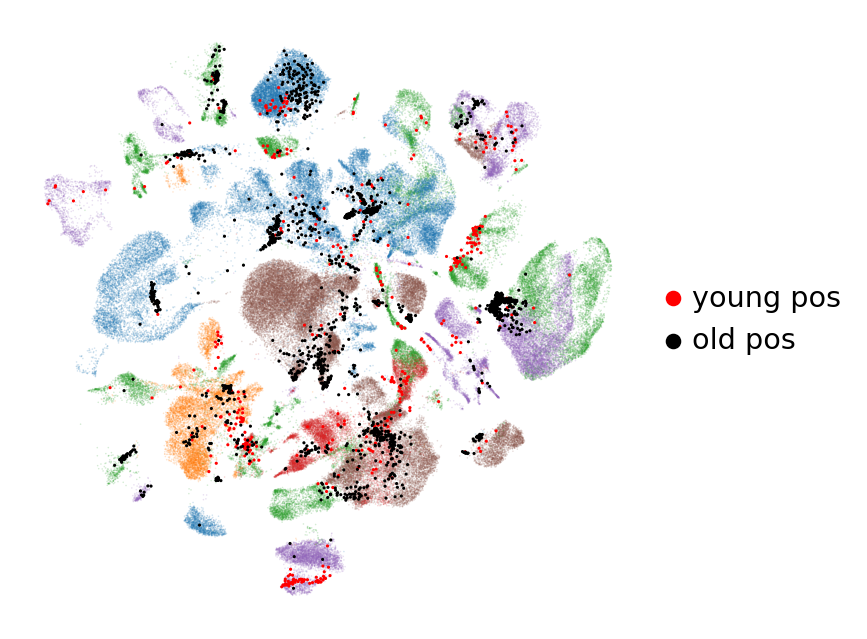

In [64]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, s = 2, color = 'Class', alpha = 0.2,
                    legend_loc = None, show = False,
                    palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

#palette = ['whitesmoke']
    
    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = 8, palette = ['red'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = 8, palette = ['k'],
               ax = ax, title = '', save = '_R1_5A_pt1.svg')

In [34]:
adata.obs[['age', 'is_sen']].groupby('age').sum()

,is_sen
age,
3m,467
24m,1901


In [35]:
adata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,...,tissue2,tissue_cell,cell_type_2,sen_score,sen_outlier,sen_outlier_v2,is_sen,Class,thing_young,thing_old
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,...,Tongue,Tongue_keratinocyte,keratinocyte,2.460360,False,False,False,parenchymal,neg,neg
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,...,Tongue,Tongue_keratinocyte,keratinocyte,2.556036,False,False,False,parenchymal,neg,neg
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,...,Tongue,Tongue_keratinocyte,keratinocyte,0.855650,False,False,False,parenchymal,neg,neg
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,...,Tongue,Tongue_keratinocyte,keratinocyte,-0.105534,False,False,False,parenchymal,neg,neg
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,...,Tongue,Tongue_keratinocyte,keratinocyte,2.755315,False,False,False,parenchymal,neg,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,...,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,0.770724,False,False,False,progenitor,neg,neg
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,...,Lymphoid,Marrow_naive B cell,B cell,0.920428,False,False,False,progenitor,neg,neg
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,...,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell,-0.078595,False,False,False,progenitor,neg,neg


/tmp/ipykernel_158729/405592675.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


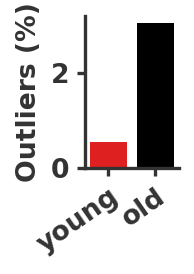

In [36]:
temp_val1 = len(adata.obs[adata.obs['thing_young'] == 'young pos'])\
    /len(adata.obs[adata.obs.age.isin(['1m', '3m'])])*100

temp_val2 = len(adata.obs[adata.obs['thing_old'] == 'old pos'])\
    /len(adata.obs[adata.obs.age.isin(['24m', '30m'])])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('Outliers (%)', size = 12, weight = 'bold', color = '0.2')

#plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/R1_5A_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_5A_pt2.svg', bbox_inches = 'tight')


plt.show()

In [37]:
aaa = adata.obs[['tissue2', 'cell_type_2', 'is_sen']].groupby(['tissue2', 'cell_type_2']).sum().reset_index()

aaa = aaa[aaa.is_sen > 0].reset_index(drop = True)

aaa

,tissue2,cell_type_2,is_sen
0,Bladder,bladder cell,97
1,Bladder,bladder urothelial cell,59
2,Bladder,endothelial cell,7
3,Brain,astrocyte,9
4,Brain,endothelial cell,9
...,...,...,...
96,Trachea,mesenchymal cell,8
97,Trachea,mesenchymal progenitor cell,13
98,Trachea,mucus secreting cell,3
99,Trachea,neuroendocrine cell,1


In [38]:
big_out = []

for y in tqdm(range(len(aaa))):
    sub = adata[(adata.obs.tissue2 == aaa.iloc[y].tissue2) & (adata.obs.cell_type_2 == aaa.iloc[y].cell_type_2)]
    
    out2 = []
    for age in ['1m', '3m', '18m', '21m', '24m', '30m']:
        age_sub = sub[sub.obs.age == age]
        
        if len(age_sub) < 100:
            out2.append(np.nan)
            continue
            
        out2.append(age_sub.obs.is_sen.sum()/len(age_sub))
    
    big_out.append([aaa.iloc[y].tissue2, aaa.iloc[y].cell_type_2] + out2)


100%|█████████████████████████████████████████| 101/101 [00:02<00:00, 46.78it/s]


In [39]:
sen = pd.DataFrame(big_out, columns = ['tissue', 'cell','1m', '3m', '18m', '21m', '24m', '30m'])

In [40]:
def get_increase(x):
    
    x = x.fillna(-1)
    
    if x['3m'] != -1:
        start = x['3m']
    elif x['1m'] != -1:
        start = x['1m']
    else:
        start = 0 #kidney podocyte has nan for 1m and 3m.. not sure how but to prevent error need this
        
        
    old = x[x.index.isin(['24m', '30m'])].max() #is max the right choice?
    
    return old - start
    

In [41]:
sen['gain'] = sen[['1m', '3m', '18m', '21m', '24m', '30m']].apply(get_increase, axis = 1)

sen['tissue_cell'] = sen.tissue + '_' + sen.cell

In [42]:
sen = sen[sen.gain > 0]

In [43]:
sen = sen.sort_values('gain', ascending = False).reset_index(drop = True)

In [44]:
sen['Class'] = sen.cell.map(class_d)

In [45]:
sen

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class
0,Pancreas,pancreatic acinar cell,NaN,0.000000,NaN,NaN,0.176724,NaN,0.176724,Pancreas_pancreatic acinar cell,parenchymal
1,Trachea,fibroblast,NaN,0.000000,NaN,NaN,0.167500,NaN,0.167500,Trachea_fibroblast,stromal
2,Lung,fibroblast,NaN,0.002358,NaN,NaN,0.156757,NaN,0.154398,Lung_fibroblast,stromal
3,Bladder,bladder cell,NaN,0.004244,NaN,NaN,0.129927,NaN,0.125683,Bladder_bladder cell,parenchymal
4,Trachea,basal cell,NaN,0.001656,NaN,NaN,0.126866,NaN,0.125210,Trachea_basal cell,epithelial
5,Trachea,macrophage,NaN,0.000000,NaN,NaN,0.122340,NaN,0.122340,Trachea_macrophage,immune
6,Heart_and_Aorta,endocardial cell,NaN,0.000000,NaN,NaN,0.118519,NaN,0.118519,Heart_and_Aorta_endocardial cell,parenchymal
7,Thymus,thymocyte,NaN,0.000000,NaN,NaN,0.115634,NaN,0.115634,Thymus_thymocyte,parenchymal
8,Pancreas,pancreatic B cell,NaN,0.003831,NaN,NaN,0.105960,NaN,0.102129,Pancreas_pancreatic B cell,parenchymal
9,Liver,hepatocyte,NaN,0.004317,NaN,NaN,0.103070,NaN,0.098754,Liver_hepatocyte,parenchymal


In [47]:
plt.rcdefaults()

### Fig 5C

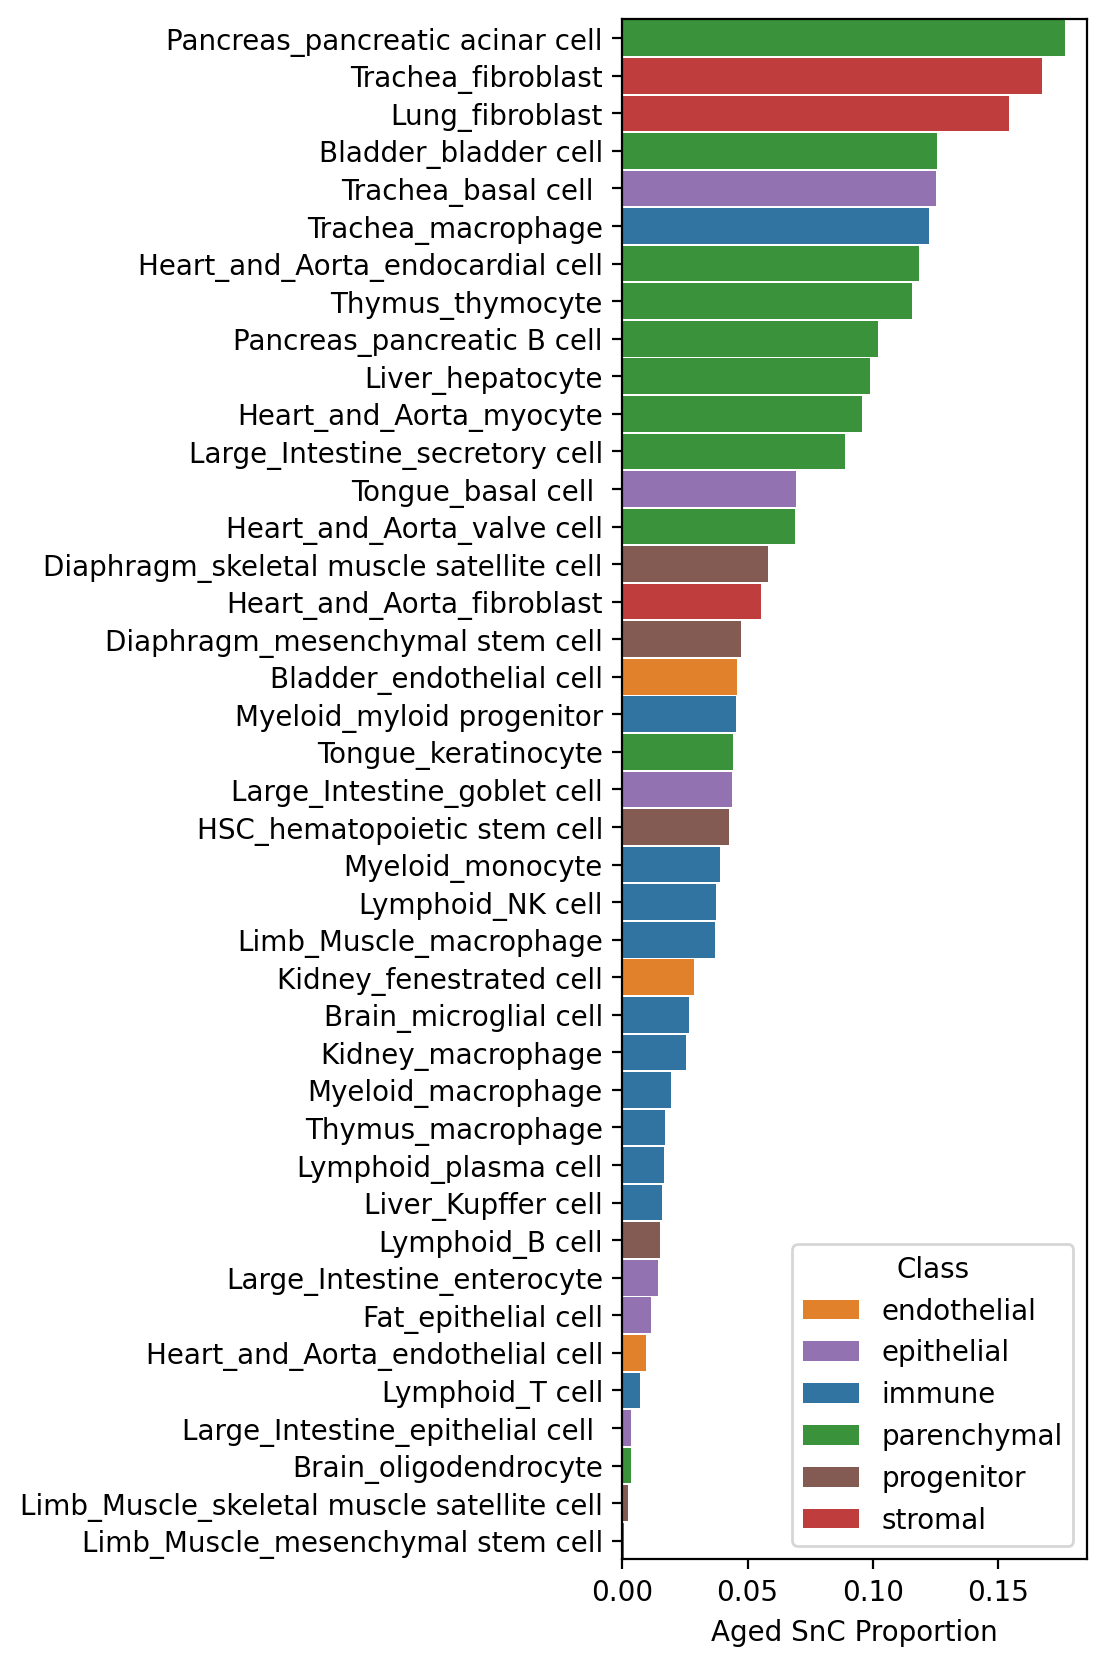

In [48]:
#v2 all
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'gain', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

plt.ylabel('')
plt.xlabel('Aged SnC Proportion')

plt.savefig('figures/R1_5C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_5C.svg', bbox_inches = 'tight')

plt.show()

In [49]:
#lets see correlation to ki67 and tert
sen.head()

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class
0,Pancreas,pancreatic acinar cell,NaN,0.000000,NaN,NaN,0.176724,NaN,0.176724,Pancreas_pancreatic acinar cell,parenchymal
1,Trachea,fibroblast,NaN,0.000000,NaN,NaN,0.167500,NaN,0.167500,Trachea_fibroblast,stromal
2,Lung,fibroblast,NaN,0.002358,NaN,NaN,0.156757,NaN,0.154398,Lung_fibroblast,stromal
3,Bladder,bladder cell,NaN,0.004244,NaN,NaN,0.129927,NaN,0.125683,Bladder_bladder cell,parenchymal
4,Trachea,basal cell,NaN,0.001656,NaN,NaN,0.126866,NaN,0.125210,Trachea_basal cell,epithelial


In [50]:
ki67i = np.where(bdata.var_names == 'Mki67')[0][0]
ki = bdata[:,ki67i]


def get_ki67_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

In [51]:
sen['ki67_pp'] = sen[['tissue', 'cell']].apply(get_ki67_pp, axis = 1)

In [52]:
i = np.where(bdata.var_names == 'Tert')[0][0]
ki = bdata[:,i]


def get_tert_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

sen['tert_pp'] = sen[['tissue', 'cell']].apply(get_tert_pp, axis = 1)

### Sup Fig 5A

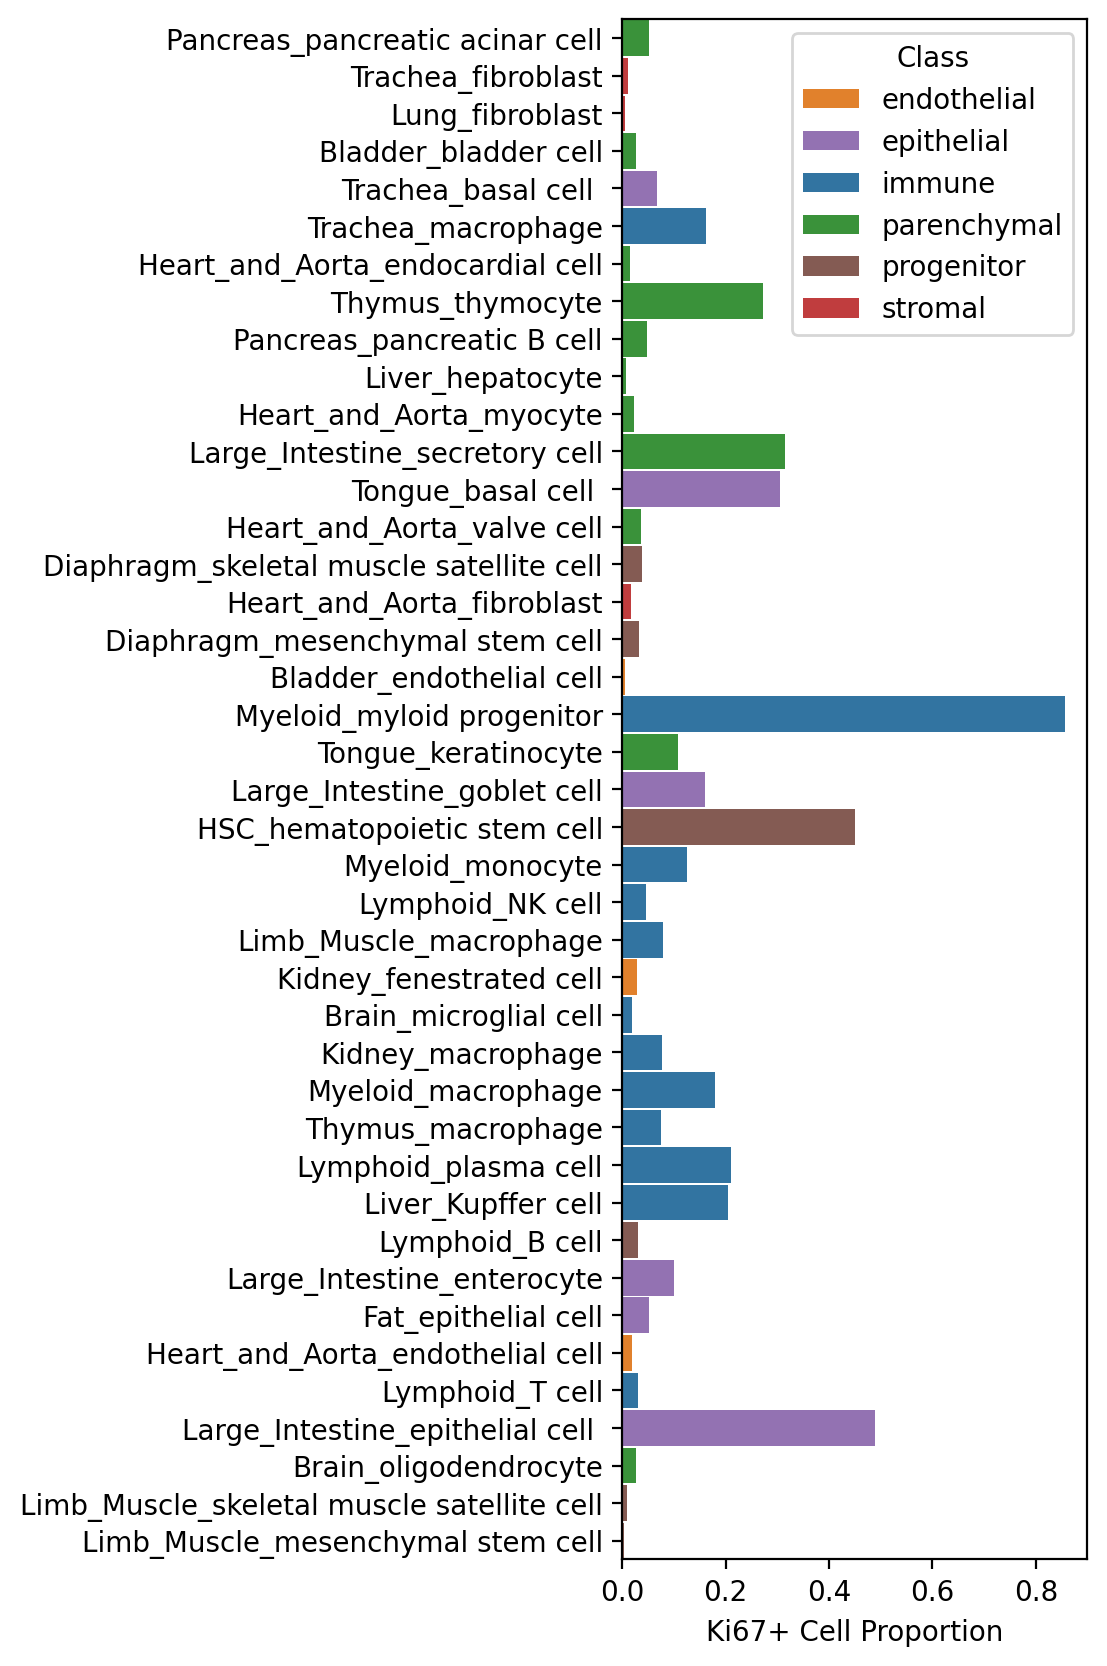

In [53]:
#pp of cells expressing ki67
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'ki67_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])



plt.ylabel('')
plt.xlabel('Ki67+ Cell Proportion')

plt.savefig('figures/R1_S5A.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S5A.svg', bbox_inches = 'tight')

plt.show()

### Sup Fig 5C

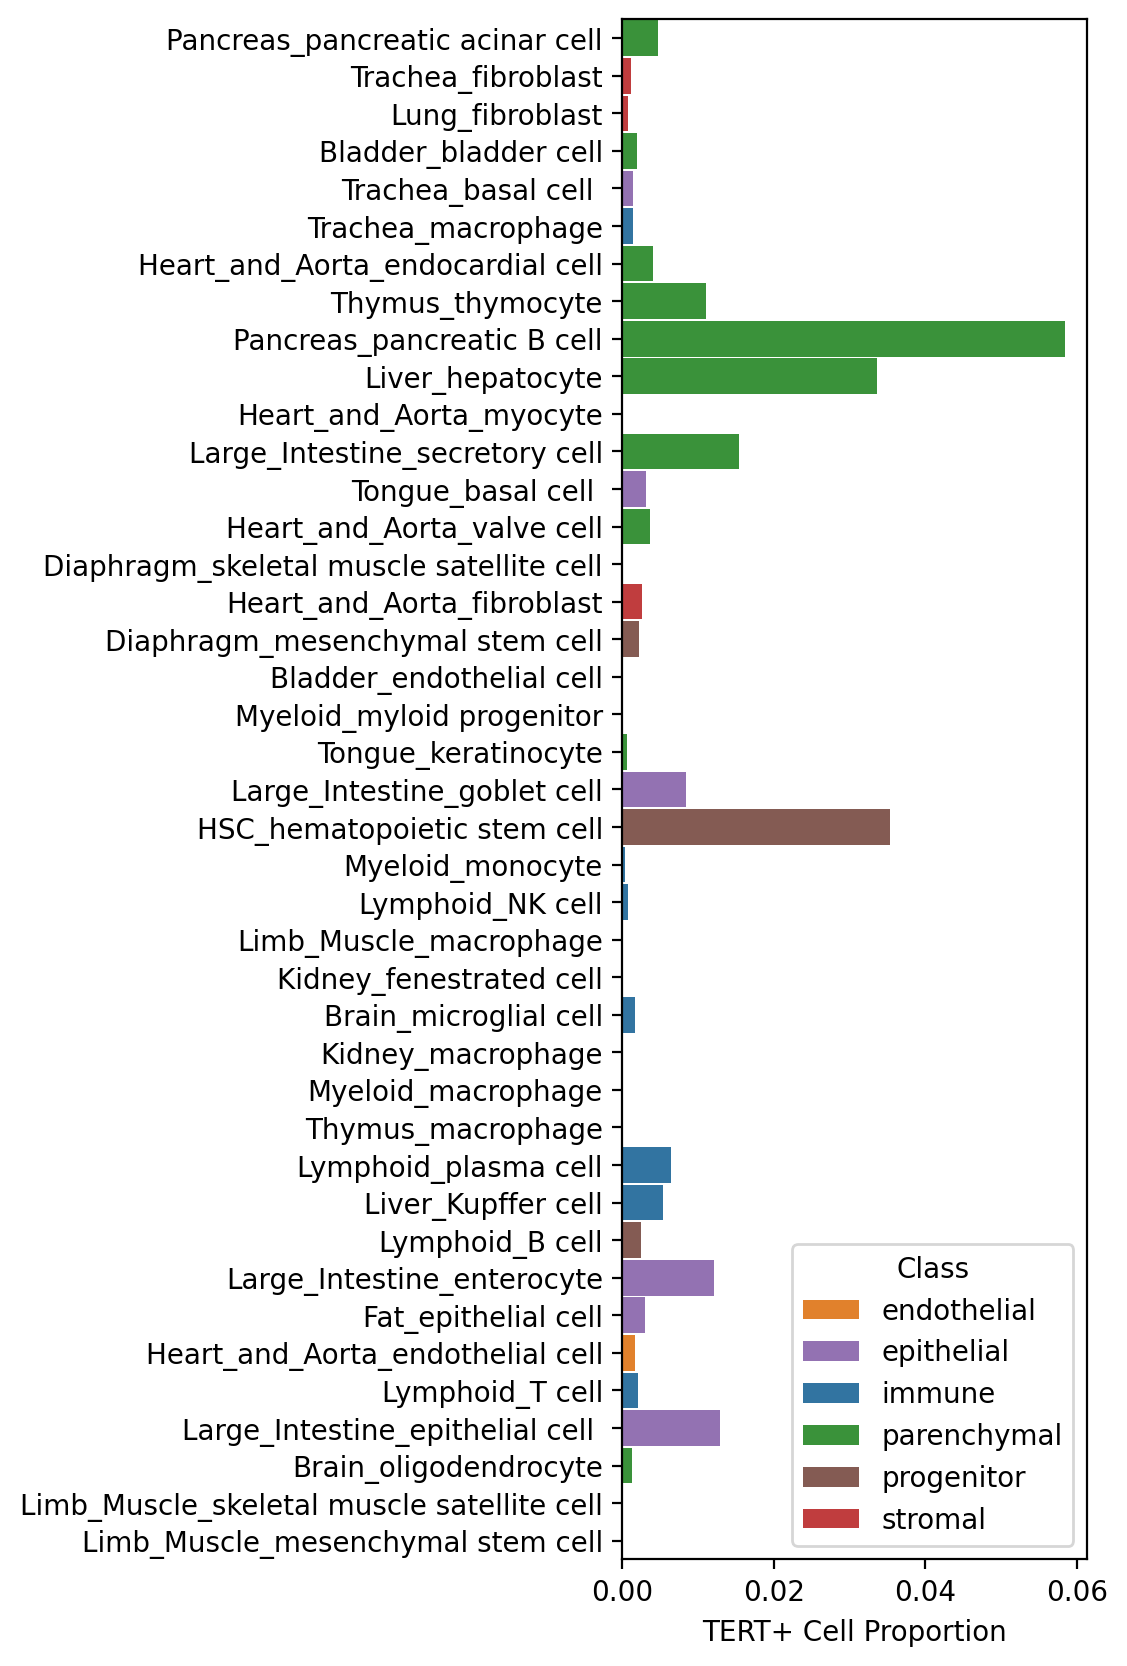

In [54]:
#pp of cells expressing tert
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'tert_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

plt.ylabel('')
plt.xlabel('TERT+ Cell Proportion')

plt.savefig('figures/R1_S5C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S5C.svg', bbox_inches = 'tight')

plt.show()

In [55]:
sen[sen.tissue == 'Large_Intestine']

,tissue,cell,1m,3m,18m,21m,24m,30m,gain,tissue_cell,Class,ki67_pp,tert_pp
11,Large_Intestine,secretory cell,NaN,0.000000,NaN,NaN,0.088889,NaN,0.088889,Large_Intestine_secretory cell,parenchymal,0.314578,0.015345
20,Large_Intestine,goblet cell,NaN,0.000000,NaN,NaN,0.043651,NaN,0.043651,Large_Intestine_goblet cell,epithelial,0.160535,0.008361
33,Large_Intestine,enterocyte,NaN,0.012755,NaN,NaN,0.027174,NaN,0.014419,Large_Intestine_enterocyte,epithelial,0.100694,0.012153
37,Large_Intestine,epithelial cell,NaN,0.000000,NaN,NaN,0.003546,NaN,0.003546,Large_Intestine_epithelial cell,epithelial,0.489655,0.012931


In [56]:
i = np.where(bdata.var_names == 'Cdkn2a')[0][0]
ki = bdata[:,i]
ki = ki[ki.obs.age.isin(['21m','24m', '30m'])]

def get_tert_pp(x):
    tissue, cell = x
    sub = ki[(ki.obs.tissue2 == tissue) & (ki.obs.cell_type_2 == cell)].X.toarray()
    a = sub[:,0]
    b = a[a >0]
    
    if len(a) == 0:
        print(tissue)
        return 0
    
    return len(b)/len(a)

sen['cdkn2a_pp'] = sen[['tissue', 'cell']].apply(get_tert_pp, axis = 1)

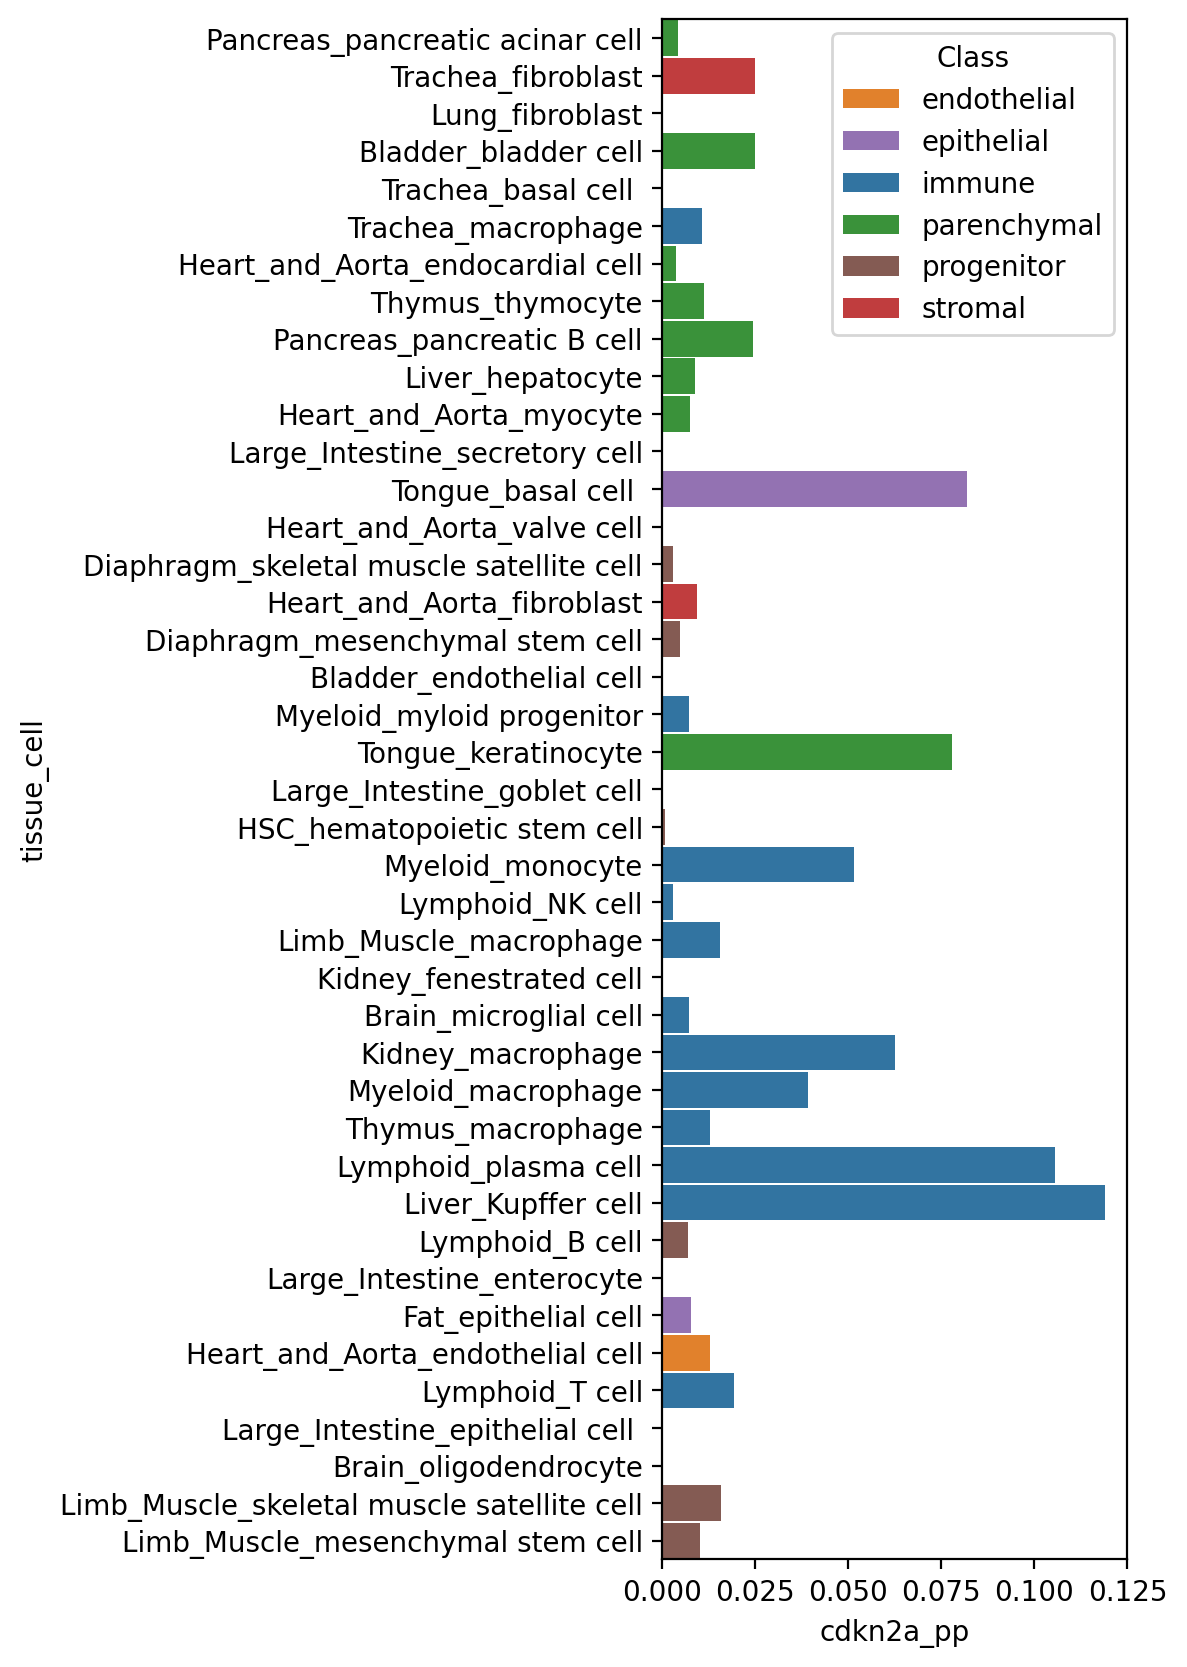

In [57]:
#pp of cells expressing cdkn2a
plt.figure(figsize = (3,10))

ax = sns.barplot(data = sen, x = 'cdkn2a_pp', y = 'tissue_cell', hue = 'Class', dodge=False, width = 0.95,
                hue_order = ['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'], 
                palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'])

In [58]:
stats.pearsonr(sen.gain, sen.ki67_pp)

PearsonRResult(statistic=-0.10701319469986526, pvalue=0.505446567814167)

In [59]:
stats.pearsonr(sen.gain, sen.tert_pp)

PearsonRResult(statistic=0.16032445187421934, pvalue=0.3166690216660307)

In [60]:
stats.pearsonr(sen.gain, sen.cdkn2a_pp)

PearsonRResult(statistic=-0.17561216320345238, pvalue=0.27209355170415456)

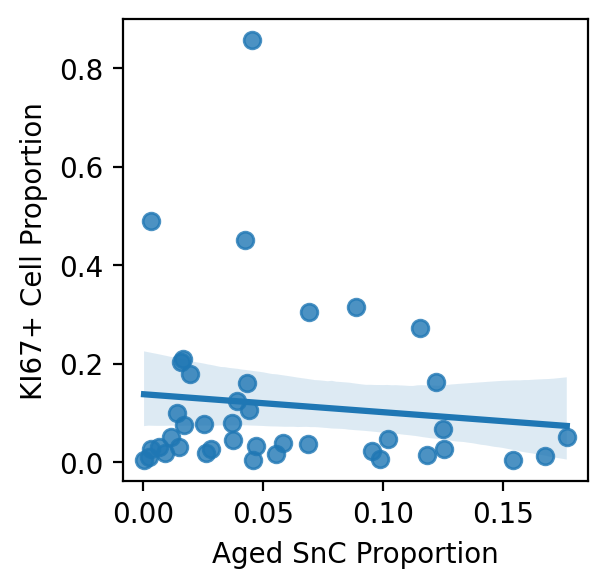

In [61]:
plt.figure(figsize = (3,3))

ax = sns.regplot(data = sen, x = 'gain', y = 'ki67_pp')

plt.xlabel('Aged SnC Proportion')
plt.ylabel('KI67+ Cell Proportion')

plt.savefig('figures/R1_S5B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S5B.svg', bbox_inches = 'tight')

plt.show()

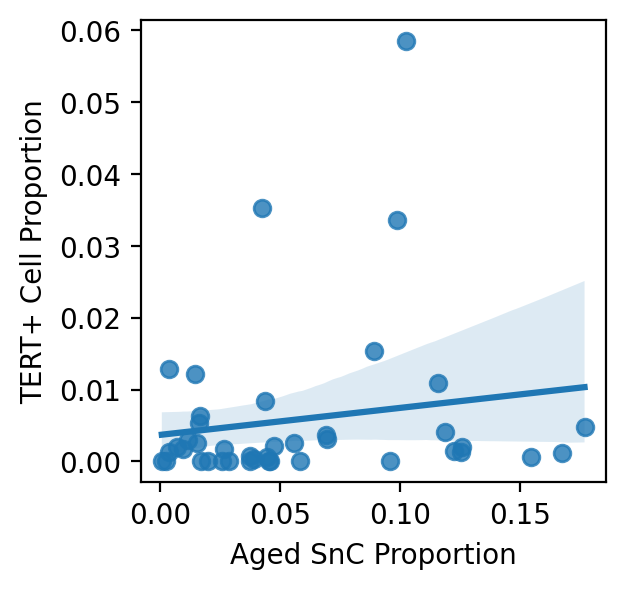

In [62]:
plt.figure(figsize = (3,3))

ax = sns.regplot(data = sen, x = 'gain', y = 'tert_pp')

plt.xlabel('Aged SnC Proportion')
plt.ylabel('TERT+ Cell Proportion')

plt.savefig('figures/R1_S5D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S5D.svg', bbox_inches = 'tight')

plt.show()